# Imports

In [2]:
import xgboost as xgb
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
import numpy as np

# Load Data

In [3]:
csv_path = os.path.abspath(os.path.join(
    os.getcwd(),
    os.pardir,
    'datasets',
    'quality_scores.csv'
))


df = pd.read_csv("../datasets/quality_scores.csv", dtype={'Experiment': str})
df['Experiment'] = df['Experiment'].apply(lambda x: int(x)*1000 if len(x)==1 else x).astype(int)


# Test Data

In [4]:
data = df[["Experiment","Index","Param1", "Param2", "Param3", "Param4", "Area sum"]]
data_train, data_test = train_test_split(data,test_size=0.2, random_state=42)

# Grid Searching


In [ ]:
param_grid = {
    'max_depth': np.arange(1,10), 
    'learning_rate': [1, 0.1],
    'n_estimators': np.arange(100,1100, step=100), 
    'subsample': np.arange(0.5,1,step=0.1), 
    #'colsample_bytree': np.arange(0.5,1,step=0.1), 
}
# 9*2*10*5=900 candidates
# 900*5 = 4500 fits
# approx. 39 min (50?)

model = xgb.XGBRegressor(objective="reg:squarederror")
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=10, 
                           scoring='neg_mean_squared_error',
                           verbose=1)

X = df[["Param1", "Param2", "Param3", "Param4"]]
y = df["Area sum"]

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X, y)


In [5]:
import pickle
#pickle.dump(grid_search, open("grid_search.pkl", "wb"))
#pickle.dump(best_model, open("best_model.pkl", "wb"))

# (XGBoost==1.6.2)
best_model = pickle.load(open("best_model.pkl", "rb"))

# (sklearn==1.2.0)
grid_search = pickle.load(open("grid_search.pkl", "rb"))
best_params = grid_search.best_params_
best_score = grid_search.best_score_


c:\Users\mpr.CMDK\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


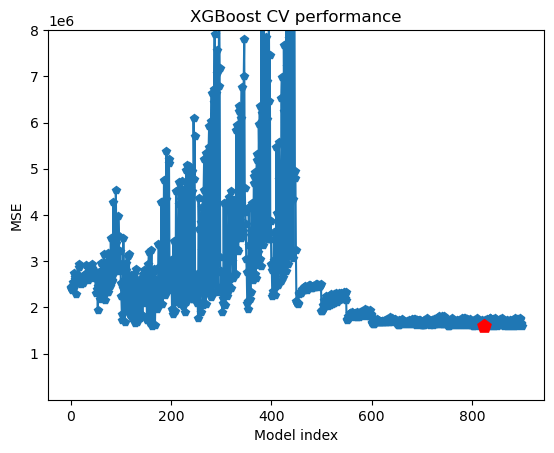

In [6]:
# list performance of all models
results = grid_search.cv_results_
mean_score = results['mean_test_score']
std_score = results['std_test_score']
params = results['params']

# number of models
N = len(mean_score)


plt.plot(-mean_score, marker='p', zorder=1)
# plt.fill_between(np.arange(0,N), -mean_score+std_score, -mean_score-std_score, alpha=0.3, zorder=0)
plt.title("XGBoost CV performance")
plt.ylabel("MSE")
plt.xlabel("Model index")
#plt.xticks(np.arange(0,N,1))

plt.scatter(results['rank_test_score'].argmin(), -best_score, color='red', s=100, marker='p', zorder=2)
plt.ylim(1,8e6)
plt.show()



In [8]:
print(best_params)
print(-best_score)

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8999999999999999}
1587154.8503193192


# Evaluate on param space

In [79]:
# With the new dataset, fit some GP-like model, as suggest a new set of parameters
dims = 4

# Parameter Space
param_bounds = [
    np.linspace(start=0, stop=5, num=21), #
    np.linspace(start=10, stop=100, num=46),
    np.linspace(start=0, stop=5, num=21),
    np.linspace(start=50, stop=300, num=101)
]

param_space = np.array( np.meshgrid(param_bounds[0],
                                    param_bounds[1],
                                    param_bounds[2],
                                    param_bounds[3])).T.reshape(-1,dims)

param_space = param_space[np.random.randint(param_space.shape[0],size=2048886)]
param_preds = best_model.predict(param_space.reshape(-1,4))

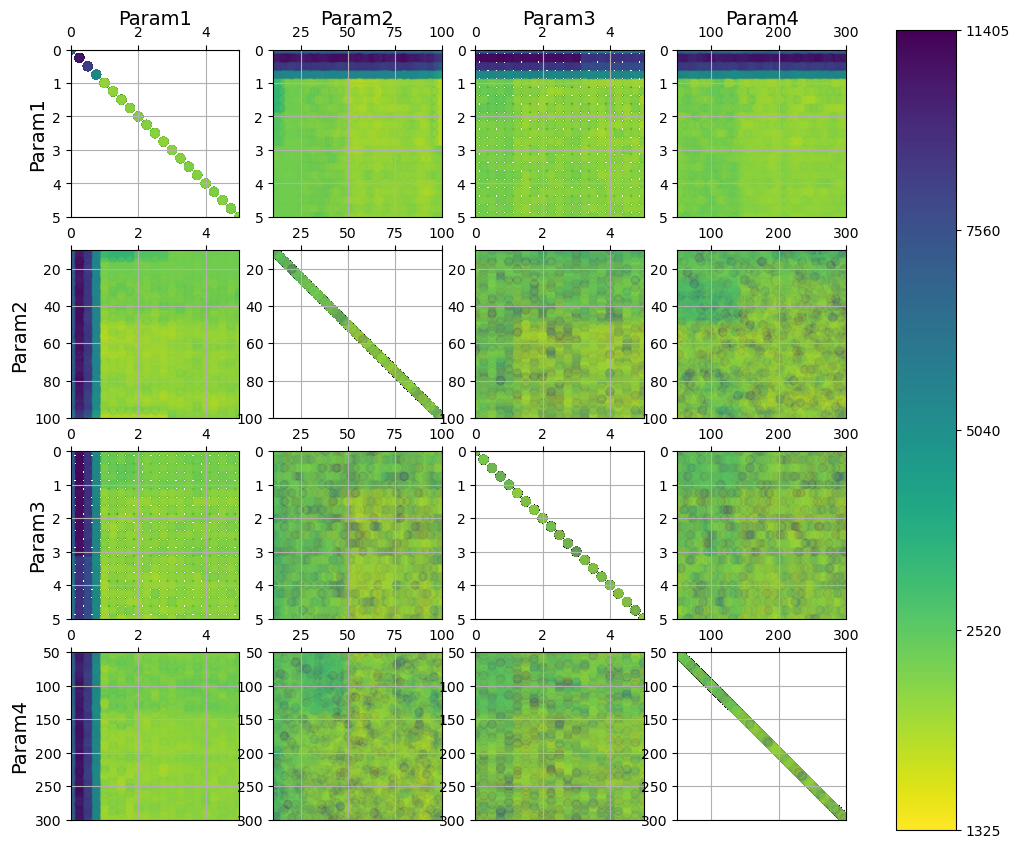

In [83]:
fig, axs = plt.subplots(4,4, figsize=(10,10))
bounds = [(0,5),(10,100),(0,5),(50,300)]

for x in range(4):
    for y in range(4):
        scatter1 = axs[x,y].scatter(param_space[:,y], param_space[:,x], c=param_preds, alpha=0.1, cmap='viridis_r', vmin=1325, vmax=11405)
        axs[x,y].set_ylim(bounds[x])
        axs[x,y].set_xlim(bounds[y])
        axs[x,y].grid()
        axs[x,y].invert_yaxis()
        axs[x,y].xaxis.tick_top()

cax = fig.add_axes([0.95, 0.1, 0.06, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='viridis_r')  # Example mappable object
cb = plt.colorbar(mappable=sm, cax=cax, ticks=[0, 0.25, 0.5, 0.75, 1])
cb.ax.set_yticklabels( ['1325', '2520', '5040', '7560', '11405'] )

# tick_labels = ['1325', '2520', '5040', '7560', '11405']
# tick_labels = ['900', '2963', '5925', '8888', '12750']

for i in range(4):
    axs[i,0].set_ylabel('Param'+str(i+1), fontsize=14)
    #axs[0,i].set_xlabel('Param'+str(i+1), fontsize=14)
    axs[0,i].text(0.5, 1.15, 'Param'+str(i+1), transform=axs[0,i].transAxes, ha='center', fontsize=14)


# Ensemble of XGBoost Models
#### ! Remember to document the inherent variance of the impurity score. We can't expect the model prediction to have less variance than the data itself.

In [6]:
# Train N models using bagging
N = 300
ensemble = []

np.random.seed(42)
rand_states = np.random.randint(0, 1000, size=N)

for i in range(N):
    df_bag = data_train.sample(100, random_state=rand_states[i])
    Xbag = df_bag[["Param1", "Param2", "Param3", "Param4"]]
    ybag = df_bag["Area sum"]

    model = xgb.XGBRegressor(**best_params, objective="reg:squarederror", random_state=42)

    model.fit(Xbag, ybag)

    ensemble.append(model)


In [7]:
# Gather predictions
predictions = []
Xtest = data_test[["Param1", "Param2", "Param3", "Param4"]]
ytest = data_test[["Area sum"]]
for i in range(N):
    predictions.append(ensemble[i].predict(Xtest))
predictions = np.array(predictions)

C:\Users\mpr.CMDK\AppData\Local\Temp\ipykernel_11172\1055388037.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merged_df = df.merge(grouped_df, left_on='Experiment', right_index=True, suffixes=('', '_sum'))


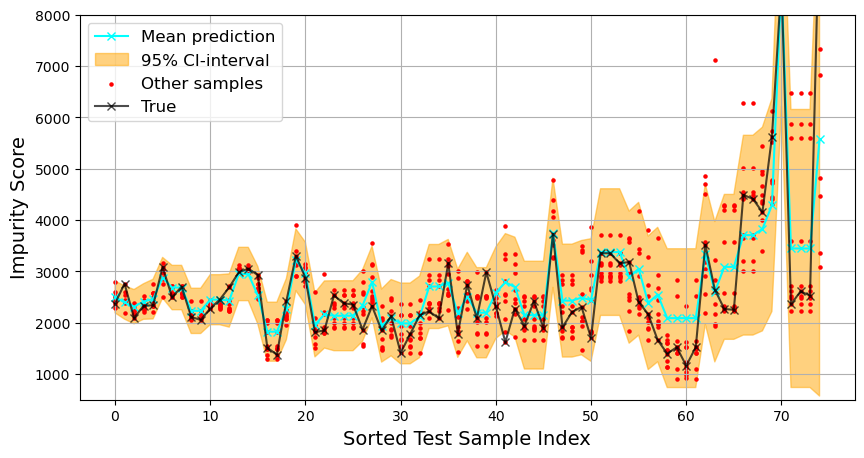

In [8]:
grouped_df = df.groupby('Experiment').agg({'Area sum': ['mean', 'std']}).fillna(0)
merged_df = df.merge(grouped_df, left_on='Experiment', right_index=True, suffixes=('', '_sum'))

data_mu = []
data_std = []
exp_num = []
for index, item in data_test.iterrows():
    mu, std = grouped_df.loc[item['Experiment']].values    
    data_mu.append(mu)
    data_std.append(std)
    exp_num.append(item['Experiment'])
    
# Calculate mean and std of predictions
mean, std = predictions.mean(axis=0), predictions.std(axis=0)
C = np.array([mean, std, ytest.values.ravel(), np.array(data_mu), np.array(data_std), np.array(exp_num)])







plt.rcParams['figure.figsize'] = [10, 5]

# Sort by types of values (0=pred-mean, 1=pred-conf-int, 2=true, 3=data-mean, 4=data-std, 5=exp_num)
B = C[:,:75].copy()
C = B[:,np.argsort(B[1])]

# Plot 95% CI-interval
x = np.arange(C.shape[1])
plt.plot(x,C[0,:], c='cyan',label='Mean prediction', marker='x')
plt.fill_between(x, C[0,:]+2*C[1,:], C[0,:]-2*C[1,:], color='orange', alpha=0.5, label='95% CI-interval')
#plt.fill_between(x, C[3,:]+3*C[4,:], C[3,:]-3*C[4,:], color='magenta', alpha=0.3, label='Inherent data variability')


for i, val in enumerate(C[5]):
    exp_df = merged_df[merged_df['Experiment'] == val]['Area sum']

    for point in exp_df:
        plt.scatter(i, point, c='r', s=5, alpha=1)
plt.scatter(i, point, c='r', s=5, alpha=1, label="Other samples")

plt.plot(x,C[2], c='black', alpha=0.7, label='True', marker='x')
plt.grid()
plt.legend(fontsize=12)
plt.ylabel("Impurity Score", fontsize=14)
plt.xlabel("Sorted Test Sample Index", fontsize=14)

plt.ylim(500,8000)

#plt.title("Not sorted")
plt.show()

# R-squared
### (maybe consider other statistical tests?)

In [55]:
data_test.shape

(232, 7)

R-squared: 0.843


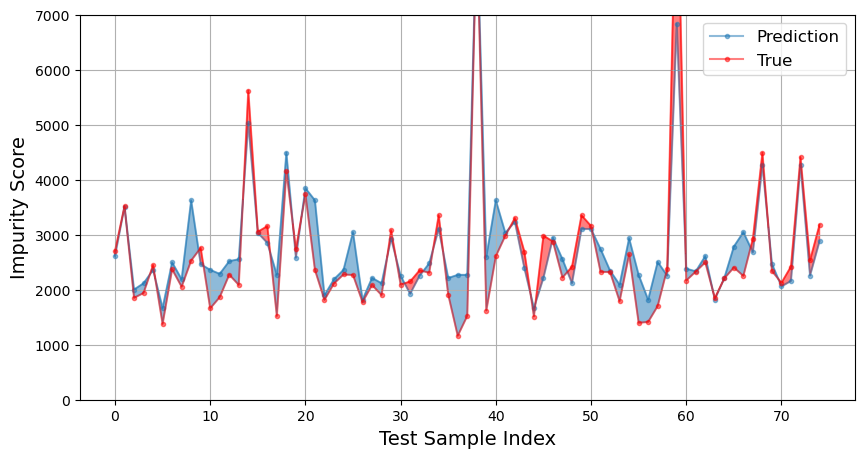

In [87]:
from scipy.stats import linregress
plt.rcParams['figure.figsize'] = [10, 5]

def calculate_r_squared(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    # print(slope)
    # print(intercept)
    # print(r_value)
    # print(p_value)
    # print(std_err)
    r_squared = r_value ** 2
    return r_squared

# Example usage
cutoff = 75
preds = best_model.predict(Xtest)
x = preds[:cutoff]
z = mean[:cutoff]
y = ytest.values.ravel()[:cutoff]
r_squared = calculate_r_squared(x, y)
plt.plot(np.arange(mean[:cutoff].shape[0]),x, color='C0', alpha=0.5, label='Prediction',marker='o',markersize=3)
# plt.plot(np.arange(mean[:cutoff].shape[0]),z, color='g', alpha=0.5, label='Bagging Prediction Mean',marker='o',markersize=3)
plt.plot(np.arange(mean[:cutoff].shape[0]),y, color='red', alpha=0.5, label='True',marker='o',markersize=3)

condition = x >= y
plt.fill_between(np.arange(mean[:cutoff].shape[0]),x,y,where=condition,interpolate=True,color='C0',alpha=0.5)
plt.fill_between(np.arange(mean[:cutoff].shape[0]),x,y,where=~condition,interpolate=True,color='red',alpha=0.5)
#plt.fill_between(np.arange(mean.shape[0]),x,y,color='C0',alpha=0.5, label='Difference')
print(f"R-squared: {r_squared:.3f}")
plt.legend(fontsize=12)
plt.ylim(0,7000)
plt.grid()
plt.ylabel('Impurity Score', fontsize=14)
plt.xlabel('Test Sample Index', fontsize=14)
plt.show()

# Single predictions

In [31]:
Xtest.shape

(232, 4)

In [32]:
best_model.predict(np.array([1.1,60,2,220]).reshape(-1,4))

array([2270.0386], dtype=float32)

array([2383.5837], dtype=float32)

In [34]:
best_model.predict(np.array([1.25,60,2,220]).reshape(-1,4))

array([1933.7065], dtype=float32)

In [80]:
# With the new dataset, fit some GP-like model, as suggest a new set of parameters
dims = 4

# Parameter Space
param_bounds = [
    np.linspace(start=0, stop=5, num=21), #
    np.linspace(start=10, stop=100, num=46),
    np.linspace(start=0, stop=5, num=21),
    np.linspace(start=50, stop=300, num=101)
]

param_space = np.array( np.meshgrid(param_bounds[0],
                                    param_bounds[1],
                                    param_bounds[2],
                                    param_bounds[3])).T.reshape(-1,dims)


In [81]:
param_predictions = best_model.predict(param_space.reshape(-1,4))

In [82]:
np.set_printoptions(suppress=True)

print(param_space[param_predictions.argmin()])
print(param_predictions.min())
print(param_space[param_predictions.argmax()])
print(param_predictions.max())

[  1.  56.   2. 200.]
1324.8708
[  0.25  94.     0.75 205.  ]
11405.243


In [83]:
print(best_model.predict(np.array([1.1,60,2,220]).reshape(-1,4)))
print(best_model.predict(np.array([1.0,60,2,220]).reshape(-1,4)))
print(best_model.predict(np.array([1.25,60,2,220]).reshape(-1,4)))
print('---')
print(best_model.predict(np.array([1.1,64,2,220]).reshape(-1,4)))
print(best_model.predict(np.array([1.25,60,2,217]).reshape(-1,4)))

[2270.0386]
[2383.5837]
[1933.7065]
---
[1962.0392]
[2162.6594]
